In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Step 1: Using SOM to identify low-resistivity regions
# Step 2: Using SOM to identify spatially separated low-resistivity regions

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from resistivity_functions import *

import pandas as pd
import seaborn as sns

import pickle

In [4]:
datafile = '../Data/rho.txt'

dataframe_original = pd.read_csv(datafile,skiprows=1,usecols=[1,2,3,4],names=['x','y','z','rho'])

In [5]:
dataframe_original = dataframe_original.replace(-9999.0,1e6)

dataframe = np.log10(dataframe_original['rho'])

In [6]:
with open('log_rho_binary_cluster.p', 'rb') as infile:
    som = pickle.load(infile)

In [7]:
data = som.dataframe_to_numpy_array()
masked_data = som.mask_data(data=data,mask_value=6)

## SOM 1: Identifying low-resistivity and high-resistivity regions

### U-matrix

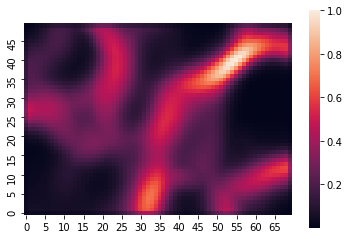

In [8]:
som.display_u_matrix()

In [9]:
som_x_dim = 50
som_y_dim = 70

vector_length = 1

In [10]:
som_weights = som.get_weights_normalized()

som_weights_flattened = np.zeros((som_x_dim*som_y_dim, vector_length))

for i in range(som_x_dim):
    for j in range(som_y_dim):
        som_weights_flattened[i*som_y_dim+j,:] = som_weights[i,j]

from sklearn.cluster import KMeans
    
clustering = KMeans(n_clusters=2,random_state=1).fit(som_weights_flattened)

labels = clustering.labels_
clusters = labels.reshape(som_x_dim,som_y_dim)

### Clustering SOM using K-Means clustering

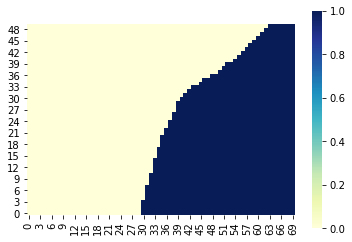

In [11]:
ax = sns.heatmap(clusters, square=True, cmap="YlGnBu")
ax.invert_yaxis()

In [12]:
normalized_data = som.normalize_data(masked_data)
reshaped_data = normalized_data.reshape(-1,1)
data_cluster = clustering.predict(reshaped_data)

In [13]:
dataframe_original['cluster_id'] = data_cluster

In [14]:
data = Data(dataframe=dataframe_original)

### Value: z

In [15]:
data.display_cross_section(variable='z',quantity='cluster_id',logscale=False, vmin=0, vmax=1)

interactive(children=(FloatSlider(value=-12.0, description='value', max=28.0, min=-50.0, step=2.0), Output()),…

### Value: x

In [16]:
data.display_cross_section(variable='x',quantity='cluster_id',logscale=False, vmin=0, vmax=1)

interactive(children=(FloatSlider(value=243050.0, description='value', max=245400.0, min=240700.0, step=50.0),…

### Value: y

In [17]:
data.display_cross_section(variable='y',quantity='cluster_id',logscale=False, vmin=0, vmax=1)

interactive(children=(FloatSlider(value=561250.0, description='value', max=565000.0, min=557500.0, step=50.0),…

In [18]:
#data_cluster = -(data_cluster - 1)

In [19]:
data_cluster_resistivity = data_cluster

In [20]:
low_resistivity_indices = np.where(data_cluster==1)

In [21]:
low_resistivity_indices = np.reshape(low_resistivity_indices,-1)

In [22]:
low_resistivity_indices = np.asarray(low_resistivity_indices)

In [23]:
list_low_resistivity_indices = low_resistivity_indices.tolist()

In [24]:
data_size = len(list_low_resistivity_indices)

In [25]:
#data_size

In [26]:
#np.size(data_cluster)

## SOM 2: Identifying spatially separated low-resistivity regions

In [27]:
dataframe_coordinates = dataframe_original[['x','y','z']]

In [28]:
dataframe = dataframe_coordinates.iloc[list_low_resistivity_indices]

In [29]:
som_x_dim = 30
som_y_dim = 50

vector_length = 3

In [30]:
som = SOM(dataframe, input_len=vector_length, som_x_dim=som_x_dim, som_y_dim=som_y_dim)

In [31]:
som.train_som(max_iterations=data_size)

### U-matrix

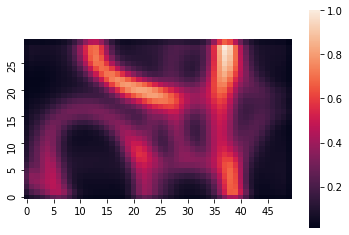

In [32]:
som.display_u_matrix()

In [33]:
with open('som_low_resistivity_coordinates.p', 'wb') as outfile:
    pickle.dump(som, outfile)

In [34]:
som_weights = som.get_weights_normalized()

In [35]:
som_weights_flattened = np.zeros((som_x_dim*som_y_dim, vector_length))

for i in range(som_x_dim):
    for j in range(som_y_dim):
        som_weights_flattened[i*som_y_dim+j,:] = som_weights[i,j]

In [36]:
from sklearn.cluster import KMeans
    
clustering = KMeans(n_clusters=3,random_state=1).fit(som_weights_flattened)

labels = clustering.labels_
clusters = labels.reshape(som_x_dim,som_y_dim)

### Clustering SOM using K-Means clustering

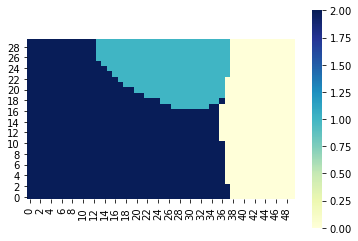

In [37]:
ax = sns.heatmap(clusters, square=True, cmap="YlGnBu")
ax.invert_yaxis()

In [38]:
#som.display_u_matrix()

In [39]:
normalized_data = som.normalize_data(dataframe)

In [40]:
data_cluster = clustering.predict(normalized_data)

In [41]:
#data_cluster

In [42]:
data_cluster = data_cluster + 1

In [43]:
data_cluster_resistivity_position = np.zeros(len(data_cluster_resistivity),dtype=int)

In [44]:
data_cluster_resistivity_position[list_low_resistivity_indices] = data_cluster

In [45]:
#data_cluster_resistivity_position

In [46]:
num_clusters = np.max(data_cluster_resistivity_position)

In [47]:
dataframe_original['cluster_id_resistivity_position'] = data_cluster_resistivity_position

In [48]:
data = Data(dataframe=dataframe_original)

### Value: z

In [49]:
data.display_cross_section(variable='z',quantity='cluster_id_resistivity_position',logscale=False, vmin=0, vmax=num_clusters)

interactive(children=(FloatSlider(value=-12.0, description='value', max=28.0, min=-50.0, step=2.0), Output()),…

### Value: x

In [50]:
data.display_cross_section(variable='x',quantity='cluster_id_resistivity_position',logscale=False, vmin=0, vmax=num_clusters)

interactive(children=(FloatSlider(value=243050.0, description='value', max=245400.0, min=240700.0, step=50.0),…

### Value: y

In [51]:
data.display_cross_section(variable='y',quantity='cluster_id_resistivity_position',logscale=False, vmin=0, vmax=num_clusters)

interactive(children=(FloatSlider(value=561250.0, description='value', max=565000.0, min=557500.0, step=50.0),…